Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-3-acb861b05d70>:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = monthly_cash_flow.groupby('cust_id').apply(compute_cash_flow_features).reset_index()
<ipython-input-3-acb861b05d70>:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_month_consistency = monthly_cash_flow.groupby('cust_id').apply(


Cash_Flow_Pattern
Stable           364
Lumpy            350
Negative         205
Steady Growth     45
Seasonal          36
Name: count, dtype: int64
                   Std_Dev_Net_Cash_Flow  Avg_Net_Cash_Flow  \
Cash_Flow_Pattern                                             
Lumpy                           0.024038           0.126899   
Negative                        0.000928           0.127611   
Seasonal                        0.049200           0.147039   
Stable                          0.000592           0.127859   
Steady Growth                   0.001437           0.127980   

                   Percent_Negative_Months  Num_Peak_Months  Peak_Month  \
Cash_Flow_Pattern                                                         
Lumpy                             0.503333         1.000000    0.606190   
Negative                          0.680465         0.854719    0.486992   
Seasonal                          0.624183         0.714976    0.543981   
Stable                            

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0wh6y2z/ymfberxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0wh6y2z/c5ekn1bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62696', 'data', 'file=/tmp/tmpd0wh6y2z/ymfberxf.json', 'init=/tmp/tmpd0wh6y2z/c5ekn1bk.json', 'output', 'file=/tmp/tmpd0wh6y2z/prophet_modele9fw6mk1/prophet_model-20250606095234.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:52:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.

Training SVM Model...
SVM Training Accuracy:  0.62375
SVM Test Accuracy:  0.62

Training XGBoost Model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:52:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


XGBoost Training Accuracy:  1.0
XGBoost Test Accuracy:  0.995

Training Logistic Regression Model...
Logistic Regression Training Accuracy:  0.6625
Logistic Regression Test Accuracy:  0.66

Training Random Forest Model...
Random Forest Training Accuracy:  1.0
Random Forest Test Accuracy:  0.98

Training Neural Network (MLP) Model...
Neural Network Training Accuracy:  0.825
Neural Network Test Accuracy:  0.785

Model Accuracy Summary:
SVM - Training: 0.6238, Test: 0.6200
XGBoost - Training: 1.0000, Test: 0.9950
Logistic Regression - Training: 0.6625, Test: 0.6600
Random Forest - Training: 1.0000, Test: 0.9800
Neural Network - Training: 0.8250, Test: 0.7850

Example Prediction (SVM):  ['Negative']
The cashflow is Negative


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


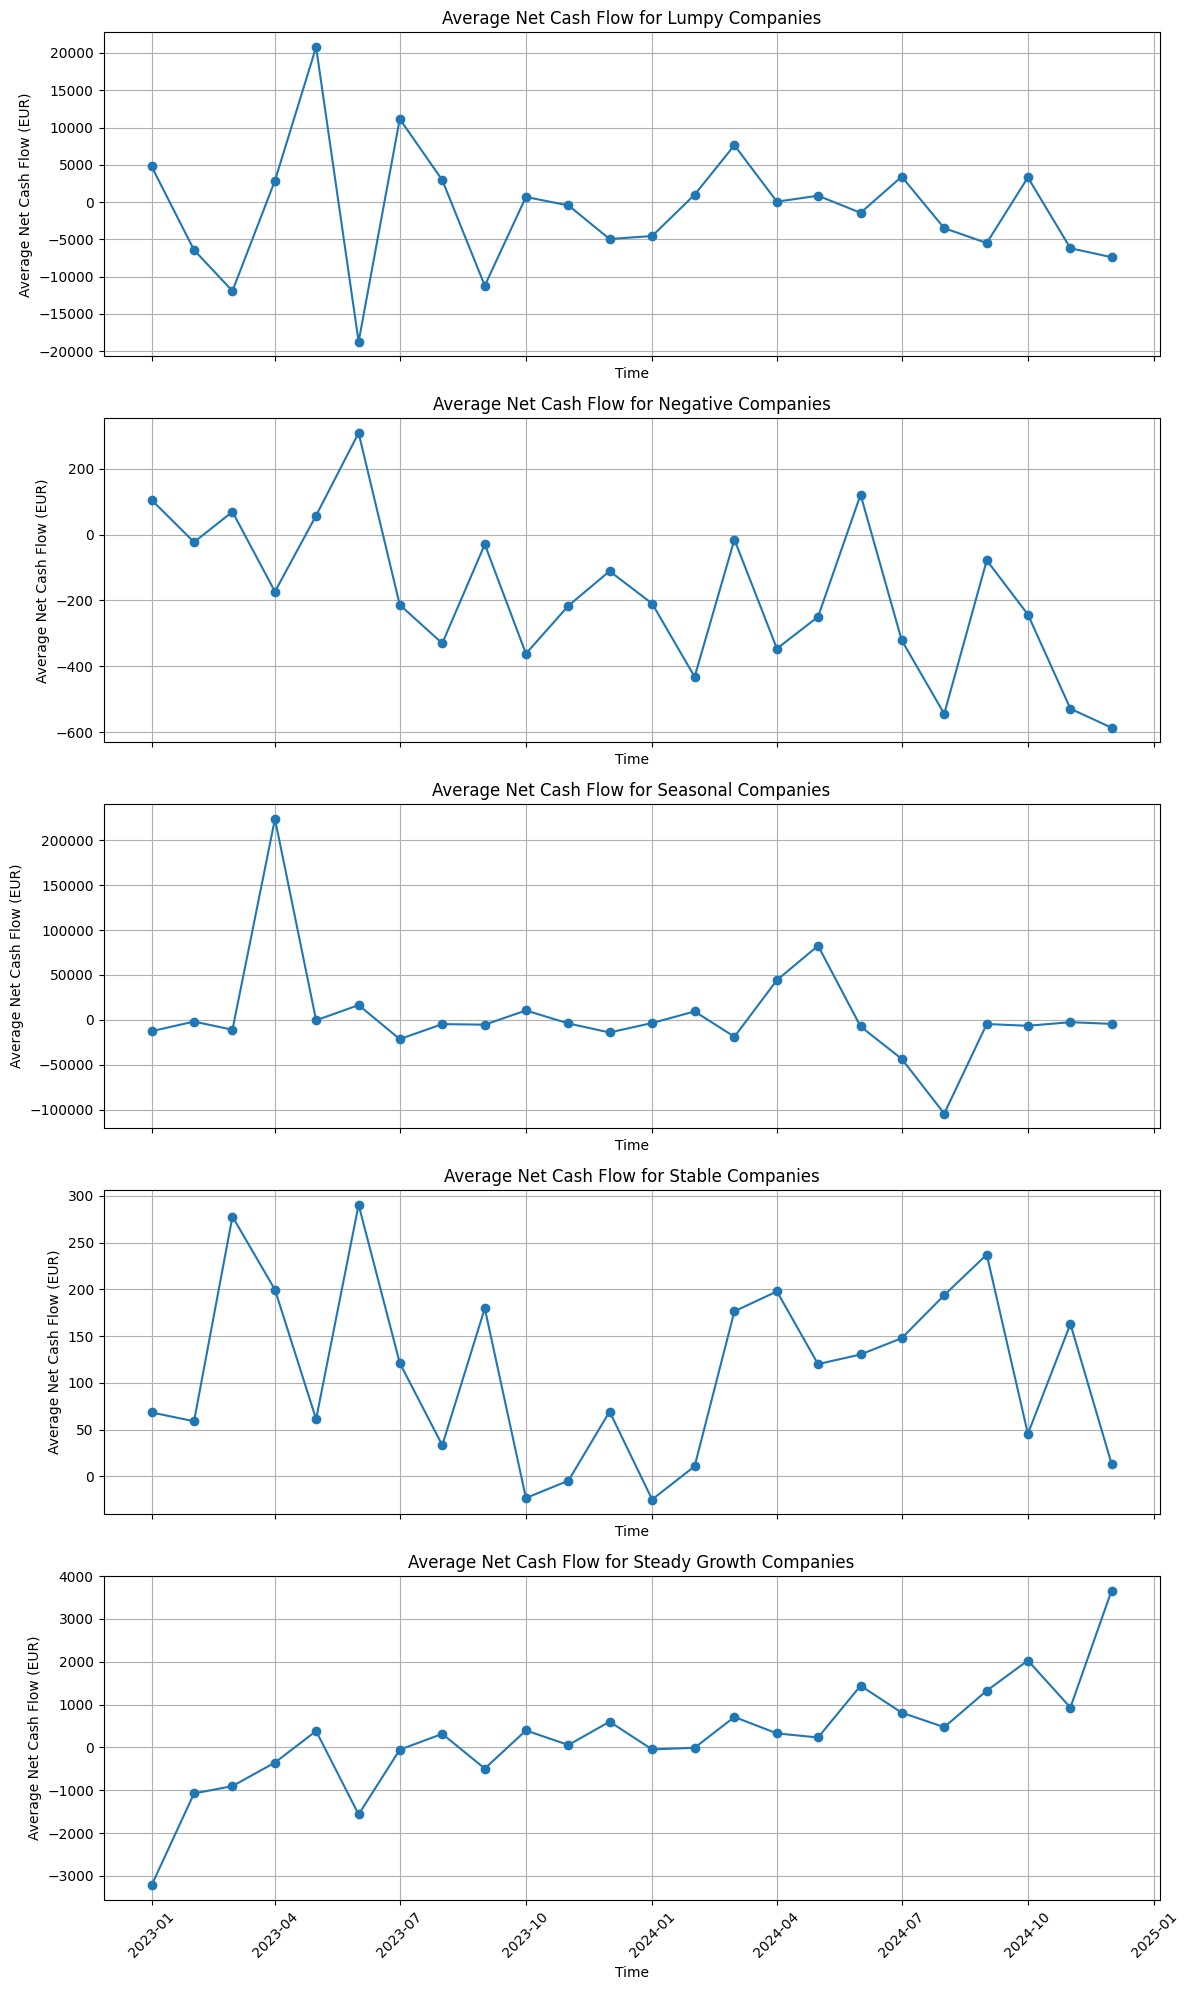

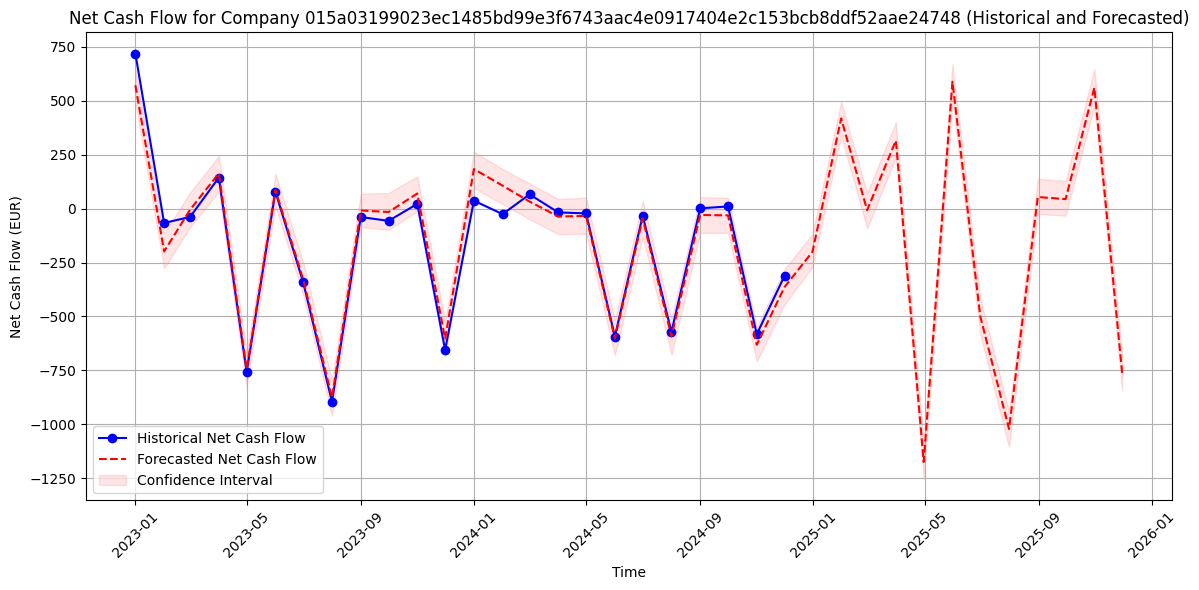

In [3]:
# -*- coding: utf-8 -*-
"""hpcfinalclassification_with_forecast_and_models.py

Enhanced version of the original classification script with added visualizations.
Plots average net cash flow vs. time for each cash flow pattern category.
Includes historical and future net cash flow graph for one company using Prophet.
Evaluates SVM, XGBoost, and Logistic Regression models for cash flow pattern prediction.
"""

# Import libraries
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import csv
import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from prophet import Prophet  # For forecasting
from xgboost import XGBClassifier  # For XGBoost model

# Install required packages
!pip install prophet
!pip install xgboost

# Accessing the dataset file (assuming Google Colab setup)
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/MyDrive/")

# Reading the dataset files
cust_df = pd.read_csv('customers.csv')
tran_df = pd.read_csv("transactions.csv", low_memory=False)

# Drop irrelevant columns
tran_df = tran_df.drop(["Channel", "Currency_trx", "Customer_IBAN", "Counterparty_IBAN", "currency", "MCC", "country_of_merchant", "Amount_Orig"], axis=1)
cust_df = cust_df.drop(['customer_type', 'CUST_GRP_ID', 'language'], axis=1)

# Step 1: Calculate Inflows (Credits) and Outflows (Debits) per customer
inflows = tran_df[tran_df['D_C'] == 'C'].groupby('cust_id')['Amount_EUR'].sum().reset_index()
inflows.rename(columns={'Amount_EUR': 'Inflows'}, inplace=True)
outflows = tran_df[tran_df['D_C'] == 'D'].groupby('cust_id')['Amount_EUR'].sum().reset_index()
outflows.rename(columns={'Amount_EUR': 'Outflows'}, inplace=True)

# Step 2: Merge Inflows and Outflows into cust_df
cust_df = cust_df.merge(inflows, on='cust_id', how='left')
cust_df = cust_df.merge(outflows, on='cust_id', how='left')

# Step 3: Handle missing values
cust_df['Inflows'] = cust_df['Inflows'].fillna(0)
cust_df['Outflows'] = cust_df['Outflows'].fillna(0)

# Step 4: Calculate Net Cash Flow
cust_df['Net_Cash_Flow'] = cust_df['Inflows'] - cust_df['Outflows']

# Step 5: Transaction Frequency
tran_count = tran_df.groupby('cust_id').size().reset_index(name='Transaction_Count')
cust_df = cust_df.merge(tran_count, on='cust_id', how='left')
cust_df['Transaction_Count'] = cust_df['Transaction_Count'].fillna(0)

# Average Inflow and Outflow Transaction Size
avg_inflow = tran_df[tran_df['D_C'] == 'C'].groupby('cust_id')['Amount_EUR'].mean().reset_index(name='Avg_Inflow_Size')
avg_outflow = tran_df[tran_df['D_C'] == 'D'].groupby('cust_id')['Amount_EUR'].mean().reset_index(name='Avg_Outflow_Size')
cust_df = cust_df.merge(avg_inflow, on='cust_id', how='left')
cust_df = cust_df.merge(avg_outflow, on='cust_id', how='left')
cust_df['Avg_Inflow_Size'] = cust_df['Avg_Inflow_Size'].fillna(0)
cust_df['Avg_Outflow_Size'] = cust_df['Avg_Outflow_Size'].fillna(0)

# Step 6: Prepare monthly net cash flow data
tran_df['BookingDatetime'] = pd.to_datetime(tran_df['BookingDatetime'])
tran_df['YearMonth'] = tran_df['BookingDatetime'].dt.to_period('M')

# Calculate monthly inflows and outflows
monthly_inflows = tran_df[tran_df['D_C'] == 'C'].groupby(['cust_id', 'YearMonth'])['Amount_EUR'].sum().reset_index()
monthly_inflows.rename(columns={'Amount_EUR': 'Monthly_Inflows'}, inplace=True)
monthly_outflows = tran_df[tran_df['D_C'] == 'D'].groupby(['cust_id', 'YearMonth'])['Amount_EUR'].sum().reset_index()
monthly_outflows.rename(columns={'Amount_EUR': 'Monthly_Outflows'}, inplace=True)

# Merge inflows and outflows
monthly_cash_flow = monthly_inflows.merge(monthly_outflows, on=['cust_id', 'YearMonth'], how='outer').fillna(0)
monthly_cash_flow['Net_Cash_Flow'] = monthly_cash_flow['Monthly_Inflows'] - monthly_cash_flow['Monthly_Outflows']

# Step 7: Calculate cash flow features
def compute_cash_flow_features(group):
    std_dev = group['Net_Cash_Flow'].std() if len(group) > 1 else 0
    avg_net_cash_flow = group['Net_Cash_Flow'].mean()
    negative_months = (group['Net_Cash_Flow'] < 0).sum()
    total_months = len(group)
    percent_negative = (negative_months / total_months * 100) if total_months > 0 else 0
    total_activity = group['Monthly_Inflows'] + group['Monthly_Outflows']
    if len(total_activity) > 0:
        threshold = total_activity.quantile(0.01)
        num_peak_months = (total_activity > threshold).sum()
        peak_month = group.loc[total_activity.idxmax(), 'YearMonth'].month
    else:
        num_peak_months = 0
        peak_month = 0
    if len(group) > 1:
        x = np.arange(len(group))
        y = group['Net_Cash_Flow'].values
        slope, _, _, _, _ = linregress(x, y)
    else:
        slope = 0
    return pd.Series({
        'Std_Dev_Net_Cash_Flow': std_dev,
        'Avg_Net_Cash_Flow': avg_net_cash_flow,
        'Percent_Negative_Months': percent_negative,
        'Num_Peak_Months': num_peak_months,
        'Peak_Month': peak_month,
        'Trend_Slope': slope
    })

new_features = monthly_cash_flow.groupby('cust_id').apply(compute_cash_flow_features).reset_index()
cust_df = cust_df.merge(new_features, on='cust_id', how='left')
cust_df['Std_Dev_Net_Cash_Flow'] = cust_df['Std_Dev_Net_Cash_Flow'].fillna(0)
cust_df['Avg_Net_Cash_Flow'] = cust_df['Avg_Net_Cash_Flow'].fillna(0)
cust_df['Percent_Negative_Months'] = cust_df['Percent_Negative_Months'].fillna(0)
cust_df['Num_Peak_Months'] = cust_df['Num_Peak_Months'].fillna(0)
cust_df['Peak_Month'] = cust_df['Peak_Month'].fillna(0)
cust_df['Trend_Slope'] = cust_df['Trend_Slope'].fillna(0)

# Peak Month Consistency
peak_month_consistency = monthly_cash_flow.groupby('cust_id').apply(
    lambda g: g['YearMonth'].dt.month.value_counts().max() / len(g['YearMonth'].dt.month.unique())
).reset_index(name='Peak_Month_Consistency')
cust_df = cust_df.merge(peak_month_consistency, on='cust_id', how='left').fillna(0)

# Note: Do NOT drop cust_id yet, as it’s needed for the merge in plotting
cust_df = cust_df.drop(columns=['BRTH_DT'], axis=1)  # Only drop BRTH_DT

# Data normalization
cust_df['Inflows'] = (cust_df['Inflows'] - cust_df['Inflows'].min()) / (cust_df['Inflows'].max() - cust_df['Inflows'].min())
cust_df['Outflows'] = (cust_df['Outflows'] - cust_df['Outflows'].min()) / (cust_df['Outflows'].max() - cust_df['Outflows'].min())
cust_df['Net_Cash_Flow'] = (cust_df['Net_Cash_Flow'] - cust_df['Net_Cash_Flow'].min()) / (cust_df['Net_Cash_Flow'].max() - cust_df['Net_Cash_Flow'].min())
cust_df['Transaction_Count'] = (cust_df['Transaction_Count'] - cust_df['Transaction_Count'].min()) / (cust_df['Transaction_Count'].max() - cust_df['Transaction_Count'].min())
cust_df['Avg_Inflow_Size'] = (cust_df['Avg_Inflow_Size'] - cust_df['Avg_Inflow_Size'].min()) / (cust_df['Avg_Inflow_Size'].max() - cust_df['Avg_Inflow_Size'].min())
cust_df['Avg_Outflow_Size'] = (cust_df['Avg_Outflow_Size'] - cust_df['Avg_Outflow_Size'].min()) / (cust_df['Avg_Outflow_Size'].max() - cust_df['Avg_Outflow_Size'].min())
cust_df['Std_Dev_Net_Cash_Flow'] = (cust_df['Std_Dev_Net_Cash_Flow'] - cust_df['Std_Dev_Net_Cash_Flow'].min()) / (cust_df['Std_Dev_Net_Cash_Flow'].max() - cust_df['Std_Dev_Net_Cash_Flow'].min())
cust_df['Avg_Net_Cash_Flow'] = (cust_df['Avg_Net_Cash_Flow'] - cust_df['Avg_Net_Cash_Flow'].min()) / (cust_df['Avg_Net_Cash_Flow'].max() - cust_df['Avg_Net_Cash_Flow'].min())
cust_df['Percent_Negative_Months'] = (cust_df['Percent_Negative_Months'] - cust_df['Percent_Negative_Months'].min()) / (cust_df['Percent_Negative_Months'].max() - cust_df['Percent_Negative_Months'].min())
cust_df['Num_Peak_Months'] = (cust_df['Num_Peak_Months'] - cust_df['Num_Peak_Months'].min()) / (cust_df['Num_Peak_Months'].max() - cust_df['Num_Peak_Months'].min())
cust_df['Peak_Month'] = (cust_df['Peak_Month'] - cust_df['Peak_Month'].min()) / (cust_df['Peak_Month'].max() - cust_df['Peak_Month'].min())
cust_df['Trend_Slope'] = (cust_df['Trend_Slope'] - cust_df['Trend_Slope'].min()) / (cust_df['Trend_Slope'].max() - cust_df['Trend_Slope'].min())
cust_df['Peak_Month_Consistency'] = (cust_df['Peak_Month_Consistency'] - cust_df['Peak_Month_Consistency'].min()) / (cust_df['Peak_Month_Consistency'].max() - cust_df['Peak_Month_Consistency'].min())

# Classification thresholds
STD_DEV_THRESHOLD = 0.0025
TREND_SLOPE_THRESHOLD = 0.0001
NEGATIVE_MONTHS_THRESHOLD = 0.6
PEAK_MONTHS_THRESHOLD = 1

# Classification function
def classify_company(row):
    median_trend_slope = 0.954792
    if (row['Std_Dev_Net_Cash_Flow'] < STD_DEV_THRESHOLD and
        abs(row['Trend_Slope'] - median_trend_slope) < TREND_SLOPE_THRESHOLD and
        row['Percent_Negative_Months'] < NEGATIVE_MONTHS_THRESHOLD):
        return 'Stable'
    elif (row['Num_Peak_Months'] < PEAK_MONTHS_THRESHOLD and
          row['Std_Dev_Net_Cash_Flow'] > STD_DEV_THRESHOLD and
          row['Peak_Month_Consistency'] > 0.2):
        return 'Seasonal'
    elif (row['Std_Dev_Net_Cash_Flow'] > STD_DEV_THRESHOLD):
        return 'Lumpy'
    elif (row['Trend_Slope'] > median_trend_slope + TREND_SLOPE_THRESHOLD and
          row['Percent_Negative_Months'] < NEGATIVE_MONTHS_THRESHOLD):
        return 'Steady Growth'
    else:
        return 'Negative'

# Apply classification
cust_df['Cash_Flow_Pattern'] = cust_df.apply(classify_company, axis=1)

# Inspect classifications
print(cust_df['Cash_Flow_Pattern'].value_counts())
print(cust_df.groupby('Cash_Flow_Pattern')[['Std_Dev_Net_Cash_Flow', 'Avg_Net_Cash_Flow',
                                            'Percent_Negative_Months', 'Num_Peak_Months',
                                            'Peak_Month', 'Trend_Slope']].mean())

# Step 8: Plot Average Net Cash Flow vs. Time for Each Category
# Ensure cust_id is the same type in both DataFrames
monthly_cash_flow['cust_id'] = monthly_cash_flow['cust_id'].astype(str)
cust_df['cust_id'] = cust_df['cust_id'].astype(str)

# Merge monthly_cash_flow with cust_df to get Cash_Flow_Pattern for each customer
monthly_cash_flow = monthly_cash_flow.merge(cust_df[['cust_id', 'Cash_Flow_Pattern']], on='cust_id', how='left')

# Convert YearMonth to datetime for plotting
monthly_cash_flow['YearMonth'] = monthly_cash_flow['YearMonth'].dt.to_timestamp()

# Group by Cash_Flow_Pattern and YearMonth, calculate mean Net_Cash_Flow
avg_cash_flow_by_category = monthly_cash_flow.groupby(['Cash_Flow_Pattern', 'YearMonth'])['Net_Cash_Flow'].mean().reset_index()

# Create a figure with subplots for each category
categories = avg_cash_flow_by_category['Cash_Flow_Pattern'].unique()
n_categories = len(categories)
fig, axes = plt.subplots(n_categories, 1, figsize=(12, 4 * n_categories), sharex=True)

# Ensure axes is iterable even for a single category
if n_categories == 1:
    axes = [axes]

# Plot each category
for idx, category in enumerate(categories):
    # Filter data for the category
    category_data = avg_cash_flow_by_category[avg_cash_flow_by_category['Cash_Flow_Pattern'] == category]

    # Plot average net cash flow over time
    axes[idx].plot(category_data['YearMonth'], category_data['Net_Cash_Flow'], marker='o', linestyle='-')

    # Customize plot
    axes[idx].set_title(f'Average Net Cash Flow for {category} Companies')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Average Net Cash Flow (EUR)')
    axes[idx].grid(True)

    # Rotate x-axis labels for readability
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('average_net_cash_flow_by_category.png')

# Step 8.1: Plot Historical and Future Net Cash Flow for One Company
# Select one company (second unique cust_id)
selected_cust_id = monthly_cash_flow['cust_id'].unique()[1]
company_data = monthly_cash_flow[monthly_cash_flow['cust_id'] == selected_cust_id][['YearMonth', 'Net_Cash_Flow']].copy()

# Prepare data for Prophet
prophet_data = company_data.rename(columns={'YearMonth': 'ds', 'Net_Cash_Flow': 'y'})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

# Create Yupfuture dates (12 months ahead)
future = model.make_future_dataframe(periods=12, freq='M')

# Forecast
forecast = model.predict(future)

# Plot historical and forecasted data
plt.figure(figsize=(12, 6))

# Historical data
plt.plot(prophet_data['ds'], prophet_data['y'], marker='o', linestyle='-', color='blue', label='Historical Net Cash Flow')

# Forecasted data
plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color='red', label='Forecasted Net Cash Flow')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Confidence Interval')

# Customize plot
plt.title(f'Net Cash Flow for Company {selected_cust_id} (Historical and Forecasted)')
plt.xlabel('Time')
plt.ylabel('Net Cash Flow (EUR)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('company_cash_flow_forecast.png')

# Step 9: Prepare Data and Train Multiple Models
# Now drop cust_id as it’s no longer needed
cust_df = cust_df.drop(columns=['cust_id'], axis=1)

# Prepare features and target
X = cust_df.drop(columns=['Cash_Flow_Pattern'], axis=1)
Y = cust_df['Cash_Flow_Pattern']

# Encode target for XG moving forward we will use this encoded target for XGBoost
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
X_train, X_test, Y_train_encoded, Y_test_encoded = train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=2)
# Model 1: SVM
print("Training SVM Model...")
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, Y_train)
svm_train_pred = svm_classifier.predict(X_train)
svm_test_pred = svm_classifier.predict(X_test)
svm_train_accuracy = accuracy_score(svm_train_pred, Y_train)
svm_test_accuracy = accuracy_score(svm_test_pred, Y_test)
print('SVM Training Accuracy: ', svm_train_accuracy)
print('SVM Test Accuracy: ', svm_test_accuracy)

# Model 2: XGBoost
print("\nTraining XGBoost Model...")
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=2)
xgb_classifier.fit(X_train, Y_train_encoded)
xgb_train_pred = xgb_classifier.predict(X_train)
xgb_test_pred = xgb_classifier.predict(X_test)
xgb_train_accuracy = accuracy_score(xgb_train_pred, Y_train_encoded)
xgb_test_accuracy = accuracy_score(xgb_test_pred, Y_test_encoded)
print('XGBoost Training Accuracy: ', xgb_train_accuracy)
print('XGBoost Test Accuracy: ', xgb_test_accuracy)

# Model 3: Logistic Regression
print("\nTraining Logistic Regression Model...")
lr_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=2)
lr_classifier.fit(X_train, Y_train)
lr_train_pred = lr_classifier.predict(X_train)
lr_test_pred = lr_classifier.predict(X_test)
lr_train_accuracy = accuracy_score(lr_train_pred, Y_train)
lr_test_accuracy = accuracy_score(lr_test_pred, Y_test)
print('Logistic Regression Training Accuracy: ', lr_train_accuracy)
print('Logistic Regression Test Accuracy: ', lr_test_accuracy)

# Model 4: Random Forest
print("\nTraining Random Forest Model...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=2)
rf_classifier.fit(X_train, Y_train)
rf_train_pred = rf_classifier.predict(X_train)
rf_test_pred = rf_classifier.predict(X_test)
rf_train_accuracy = accuracy_score(rf_train_pred, Y_train)
rf_test_accuracy = accuracy_score(rf_test_pred, Y_test)
print('Random Forest Training Accuracy: ', rf_train_accuracy)
print('Random Forest Test Accuracy: ', rf_test_accuracy)

# Model 5: Neural Network (MLP)
print("\nTraining Neural Network (MLP) Model...")
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=2)
mlp_classifier.fit(X_train, Y_train_encoded)
mlp_train_pred = mlp_classifier.predict(X_train)
mlp_test_pred = mlp_classifier.predict(X_test)
mlp_train_accuracy = accuracy_score(mlp_train_pred, Y_train_encoded)
mlp_test_accuracy = accuracy_score(mlp_test_pred, Y_test_encoded)
print('Neural Network Training Accuracy: ', mlp_train_accuracy)
print('Neural Network Test Accuracy: ', mlp_test_accuracy)

# Summary of accuracies
print("\nModel Accuracy Summary:")
print(f"SVM - Training: {svm_train_accuracy:.4f}, Test: {svm_test_accuracy:.4f}")
print(f"XGBoost - Training: {xgb_train_accuracy:.4f}, Test: {xgb_test_accuracy:.4f}")
print(f"Logistic Regression - Training: {lr_train_accuracy:.4f}, Test: {lr_test_accuracy:.4f}")
print(f"Random Forest - Training: {rf_train_accuracy:.4f}, Test: {rf_test_accuracy:.4f}")
print(f"Neural Network - Training: {mlp_train_accuracy:.4f}, Test: {mlp_test_accuracy:.4f}")

# Example prediction (using SVM as in original code)
input_data = ([1, 0.000042, 0.000069, 0.305069, 0.000159, 0.000287, 0.002062, 0.000168, 0.127619, 1.000, 0.666667, 0.25, 0.954761, 0.416667])
numpy_array = np.asarray(input_data)
input_data_reshaping = numpy_array.reshape(1, -1)
prediction = svm_classifier.predict(input_data_reshaping)
print("\nExample Prediction (SVM): ", prediction)

if prediction[0] == 'Seasonal':
    print('The cashflow is Seasonal')
elif prediction[0] == 'Stable':
    print('The cashflow is Stable')
elif prediction[0] == 'Lumpy':
    print('The cashflow is Lumpy')
elif prediction[0] == 'Steady Growth':
    print('The cashflow is Steady Growth')
elif prediction[0] == 'Negative':
    print('The cashflow is Negative')